In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FixedLocator, FixedFormatter
from textwrap import fill
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import glob

import os

In [ ]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


# Deployment

In [ ]:
path = r"../data/table-28-graduates"
df = load_df(path, skip_rows=13)

In [ ]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [ ]:

def keep_totals_slice(df, filters):
    """
    Filters a DataFrame by multiple equality conditions passed as keyword args.
    Example:
        keep_totals_slice(df,
            {
                "CAH level marker": "CAH level 3",
                "Level of study": "All",
                "Mode of study": "All",
                "Category marker": "Sex",
                "Category": "Female"
            }
        )
    """
    mask = pd.Series(True, index=df.index)
    for col, value in filters.items():
        mask &= df[col].eq(value)
    return df.loc[mask].copy()


In [ ]:
slice = { 
    "Subject area of degree": "10 Engineering and technology",
    "Level of qualification obtained": "All",
    "Mode of former study": "All",
    "Interim study": "Include significant interim study",
}
df_keep = keep_totals_slice(df, slice)
print(df_keep.shape)

df_grad = df_keep[~df_keep["Activity"].isin(["Total with known outcomes", "Non-respondents", "Total"])].copy()
df_grad.sample(20)
print(df_grad.shape)

(20137, 9)
(15490, 9)


In [ ]:
duplicates = df_grad[df_grad.duplicated(keep=False)]
duplicates.head(30)

,UKPRN,Provider name,Subject area of degree,Activity,Interim study,Level of qualification obtained,Mode of former study,Academic year,Number


In [ ]:
d = df_grad.copy()

In [ ]:
before = len(d)
d = d.drop_duplicates(subset=["UKPRN", "Academic year", "Activity"])
after = len(d)
print(f"[QA] Dropped duplicate rows on (UKPRN, Academic year, Activity): {before - after}")


[QA] Dropped duplicate rows on (UKPRN, Academic year, Activity): 60


In [ ]:
df_grad = d.copy()

In [ ]:
def normalize_year_order(df, year_col="Academic year"):
    # Put academic years in chronological order (e.g., "2017/18" -> 2017 key)
    key = df[year_col].astype(str).str.slice(0, 4).astype(int)
    return df.assign(_yearkey=key).sort_values(["_yearkey", year_col]).drop(columns="_yearkey")


In [ ]:
cat_map = {
    "Full-time employment":                                   "In work",
    "Part-time employment":                                   "In work",

    "Employment and further study":                           "In work & study",  # NBSP-normalised (see mapper)

    "Full-time further study":                                "Further study",
    "Part-time further study":                                "Further study",

    "Unemployed":                                             "Unemployed",

    "Voluntary or unpaid work":                               "Other",
    "Other including travel, caring for someone or retired":  "Other",
    "Unknown pattern of employment":                          "Other",
    "Unknown pattern of further study":                       "Other",
}


In [ ]:
def to_bucket(activity: str) -> str:
    a = (str(activity).replace("\xa0", " ").strip())
    return cat_map.get(a, "Other")  # fallback if anything unexpected appears


In [ ]:
df = df_grad.copy()
df["Dest"] = df["Activity"].map(to_bucket)

# # (Optional) restrict to Engineering if your frame mixes subjects
# df = df[df["Subject area of degree"].eq("10 Engineering and technology")].copy()

# (Optional) apply any “Total / Include significant interim study / All” filters you use elsewhere
# e.g., df = df.query("`Interim study` == 'Include significant interim study' and `Level of qualification obtained` == 'All' and `Mode of former study` == 'All'")

# 2) Aggregate counts by year x destination
by_dest_counts = (df.groupby(["Academic year", "Dest"], as_index=False)["Number"]
                    .sum())
by_dest_counts = normalize_year_order(by_dest_counts, "Academic year")

# Totals per year (for employment rate)
year_tot = (by_dest_counts.groupby("Academic year", as_index=False)["Number"]
                        .sum()
                        .rename(columns={"Number": "YearTotal"}))

# Employment rate = (In work + In work & study) / total
emp = (by_dest_counts[by_dest_counts["Dest"].isin(["In work","In work & study"])]
          .groupby("Academic year", as_index=False)["Number"].sum()
          .merge(year_tot, on="Academic year", how="left"))
emp["Employment rate (%)"] = 100 * emp["Number"] / emp["YearTotal"]
emp = normalize_year_order(emp, "Academic year")

In [ ]:
def plot_outcomes_stacked_counts(by_dest_counts, title, out_basename, chart_dir="chart-5"):

    publication_rc()
    # Pivot to counts
    pvt = (by_dest_counts.pivot_table(index="Academic year",
                                      columns="Dest",
                                      values="Number",
                                      aggfunc="sum")
                        .fillna(0))

    # Column order
    order = ["In work", "In work & study", "Further study", "Unemployed", "Other"]
    cols = [c for c in order if c in pvt.columns] + [c for c in pvt.columns if c not in order]
    pvt = pvt[cols]

    # Chronological x-order
    pvt = pvt.iloc[pvt.index.str.slice(0, 4).astype(int).argsort()]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(len(pvt))
    colors = {
        "In work":           "#1f77b4",
        "In work & study":   "#2ca02c",
        "Further study":     "#9467bd",
        "Unemployed":        "#d62728",
        "Other":             "#8c564b",
    }
    
    colors = {
    "In work":           "#1B9E77",  # green
    "In work & study":   "#66A61E",  # olive/green
    "Further study":     "#7570B3",  # violet
    "Unemployed":        "#D95F02",  # orange-red
    "Other":             "#666666",  # gray
}
    
    for col in pvt.columns:
        ax.bar(pvt.index, pvt[col].values, bottom=bottom,
               label=col, color=colors.get(col, None))
        bottom += pvt[col].values

    ax.set_ylabel("Number of respondents", fontweight="bold")
    ax.set_xlabel("Academic year")
    ax.set_title(title, fontweight="bold", pad=12)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.tick_params(axis="x", labelrotation=30)
    ax.legend(title="Destination", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    plt.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


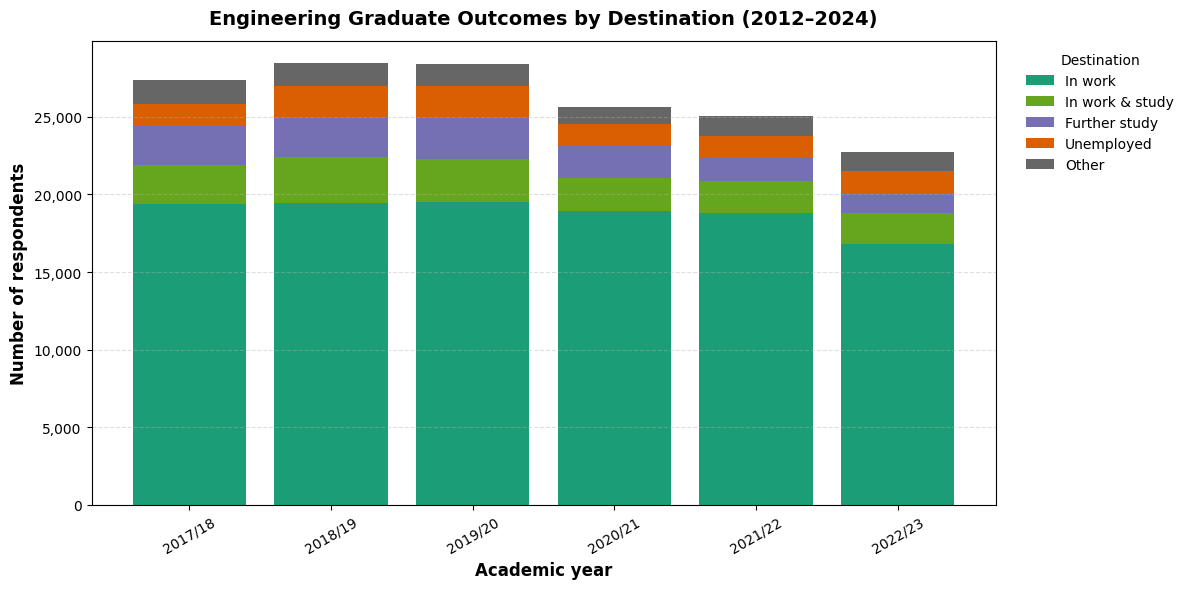

In [ ]:
plot_outcomes_stacked_counts(
    by_dest_counts,
    title="Engineering Graduate Outcomes by Destination (2012–2024)",
    out_basename="eng_outcomes_stacked_counts"
)


In [ ]:
print(df_grad.groupby("Academic year")["Number"].sum()
      .sort_index(key=lambda s: s.astype(str).str[:4].astype(int))
      .to_string())


Academic year
2017/18    27355
2018/19    28485
2019/20    28435
2020/21    25630
2021/22    25035
2022/23    22720
